<br> 
<br> 
<br> 
# Finnish Part of Speech Tagger (POS), End to End Guide

Date: 20.08.2018
<br>Author: Mikael Koli


## Introduction <a class="anchor" id="H1"></a>
Couple of months ago I got my hands on a data set of stock news headers. My intention was to test hypothesis from behavioral finance on Finnish stock markets. I thought I could try a machine learning algorithm on the problem but I was not satisfied with the simple bag-of-words approaches. It felt that these models only memorize the occurences of each word and do not really know anything else about these words. I wanted the model at least to know the functions of each word in a sentence, and for this I needed a Part of Speech tagger (POS). I have never been particularly interested in linguistics but suddenly when it was framed as a data problem, I was in.

So I started searching if there were any existing POS taggers. Even though the most widely used Natural Language Processing (NLP) library for Python, NLTK, does have extensive support for Finnish (for example stemmer, stopword list and some corpus), there were no Finnish POS taggers nor POS tagged corpus. The most promising lead I found was NLP hackers' tutorial (https://nlpforhackers.io/training-pos-tagger/) which had some awesome code examples in it. I found the list of features and way to extract them interesting, though, I was sceptical how these features would play out on Finnish text. 

But now when I had general understanding of the model for the job, I still needed some fuel for my tagger: labeled sentences. It turned out that University of Helsinki had some tagged sentences available but the problem was that there were limited amount of documentation available for the data they had. In this guide I will go through my learning process and show you how you can make your own POS tagger from scratch providing all the code you need. Even though the language here is Finnish, the process of building a good tagger should be similar regardless of language. We will also go through how to tweak the tagger and do diagnostics on it.

You can freely use the code in this notebook but I would highly appreciate acknowledgement if you do so. You can also find my current version of the project from my Github: https://github.com/Miksus/Syntags

In case you are just interested in the project itself, I would suggest to just skip the code blocks or even jump directly to the section [Problem Framing](#H7).


## Navigation:
* [Introduction](#H1)
* [Setup](#H2)
* [Hands on with the data](#H3)
* [Structuring the data](#H4)
* [Analysis of Input](#H5)
* [Analysis of Labels](#H6)
* [Problem Framing](#H7)
* [Modelling](#H8)
* [Splitting the data](#H9)
* [Transformation and Feature Engineering](#H10)
* [Final Evaluation and Conclusion](#H11)

## Setup<a class="anchor" id="H2"></a>
I use Python 3 with Pandas, Numpy, Matplotlib and Scikit Learn. If you do not have those installed, there are extensive amount of online tutorials how to install them.

In [1]:
# There are some unimportant but
# annoying warnings with my current
# setup
import warnings
warnings.filterwarnings('ignore')


import sys
import pandas as pd
import numpy as np
import sklearn
import matplotlib
print('Requirements')
print('Python version: \t{}'.format(sys.version))
print('Pandas version: \t{}'.format(pd.__version__))
print('Numpy version:  \t{}'.format(np.__version__))
print('Matplotlib version:  \t{}'.format(matplotlib.__version__))
print('Scikit learn version: \t{}'.format(sklearn.__version__))


Requirements
Python version: 	3.5.2 (v3.5.2:4def2a2901a5, Jun 25 2016, 22:18:55) [MSC v.1900 64 bit (AMD64)]
Pandas version: 	0.22.0
Numpy version:  	1.15.0
Matplotlib version:  	2.1.0
Scikit learn version: 	0.19.2


## Hands on with the data<a class="anchor" id="H3"></a>
The data can be found at University of Helsinki's website: http://www.ling.helsinki.fi/kieliteknologia/tutkimus/treebank/sources/.
<br>I used the sample file _ftb3.tgz_ which is about 3.7 gigabytes unpacked. The problem is that the file cannot be be inspected with a text editor so we will inspect it with code. For the sake of simplicity, I have taken the first 20 000 sentences as subsample pretending it to be the complete data. 

Also, the file extension of the actual file is "conllx" but that is just for indicating its structure. The file is in plain text.

In [2]:
file = 'ftb3_subsample.conllx'

In [3]:
def inspect_file(filename, n_rows):
    "Return n_rows of the file"
    
    cont, n_sents = [], 0
    with open(filename, 'r', encoding='utf-8') as f_read:
        
        for n, row in enumerate(f_read):
            cont.append(row)
            if n+1 == n_rows:
                break
                
    return '\n'.join(cont)

In [4]:
print(inspect_file(file, 5))

<s><loc file="JRC_Acquis Corpus/fi/1958/jrc31958Q1101-fi.xml" line="28,29,30,31,32,33"/>

1	NEUVOSTO	neuvosto	N	N	N Nom Sg Cap	2	attr	_	_

2	EURATOMIN	Euratom	N	N	N Prop Gen Sg Cap	3	attr	_	_

3	HANKINTAKESKUKSEN	hankinta#keskus	N	N	N Gen Sg Cap	4	attr	_	_

4	PERUSSÄÄNTÖ	perus#sääntö	N	N	N Nom Sg Cap	7	attr	_	_



The file's structure might be confusing at first glance. The first row determines the source of the sentence (beginning of a sentence is marked with "$<s>$") and the following rows represent words in a sentence. A sentence ends to a line marked with "$<\s>$" and the numbering on the first column starts from beginning. Tab or _\t_ is the separator of cells.

The table would look like this if properly structured:

| Word number | Word     | Base word | Part of Speech | Part of Speech | Morphology   | Relation | Function | Empty | Empty |
|-------------|----------|-----------|----------------|----------------|--------------|----------|----------|-------|-------|
|   1         | NEUVOSTO | neuvosto  | N              | N              | N Nom Sg Cap | 2        | attr     | -     | -     |
|   2         | EURATOMIN| Euratom   | N              | N              | Prop Gen Sg Cap| 3      | attr     | -     | -     |
|   3         | HANKINTAKESKUKSEN| hankinta#keskus| N | N          | Gen Sg Cap   | 4        | attr     | -     | -     |

<br><br>
I am unsure what those two last columns represents but they are intentionally left blank by the researchers. Also, for some reason the Part of Speech column seems to be duplicated. My assumption is that the second of the columns is meant to be tags for the base word but I did not find any instances where the values of these columns differ.

Short description of the other columns:
1. Word number: 
 - the index of the word in the sentence (number 1 is first word of a sentence)
2. Word:	           
 - the actual word
3. Base word:       
 - base form of the word (components of a combination word are separated with character "_#_")
4. Part of Speech:  
 - POS tag of the word (Verb, noun, adjective, conjuction, etc.)
5. Morphology
 - Detailed description of the word's morphological structure
6. Relation
 - Relations of the words in the parse tree
7. Function
 - Function of the word in the sentence (subject, object, main, etc.)
 
 
Next we go deeper how to read the file for our purpose.

### Structuring the data<a class="anchor" id="H4"></a>
First we import pandas for handling the table. We make a similar function as we did before and loop it through to collect the rows and tabulate the data. We also want a column numbering the sentences. We name this as column _Sentence_. 

In addition, we will remove the last two empty columns and symbol words. 

In [5]:
import pandas as pd

def read_ftb_data(filename, n_sentences=1000):
    
    columns_list = ['Word', 'Base word', 'Part of Speech', 'Part of Speech, base', 'Morphology', 'Relation', 'Function', '', '']
    index =['Sentence', '#']
    
    column_locs = list(range(len(index+columns_list)))
    n_sents, cont = 1, []
    with open(filename, 'r', encoding='utf-8') as f_read:
        for n, row in enumerate(f_read):
            if '<s>' in row or len(row) == 0:
                # Sentence source informations
                # are not our concern
                continue
            elif '</s>' in row:
                # End of sentence
                n_sents += 1
                if n_sents == n_sentences:
                    break
                else:
                    continue

            # Splitting the row to list
            # Adding the sentence numbering,
            # appending to the container
            # and removing the unneeded columns.
            row = row.replace('\n', '').split('\t')
            row = [n_sents]+row
            row = [row[col] for col in column_locs]
            cont.append(row)

    df = pd.DataFrame(cont, columns=index+columns_list)
    df = df.set_index(index)
    
    # Removing the empty columns
    df = df.drop('', axis=1)
    # Selecting rows where Part of Speech is not Punct
    df = df[df['Part of Speech'] != 'Punct']
    return df

In [6]:
df = read_ftb_data(file, 1000000)
df.head()

Word        Base word Part of Speech  \
Sentence #                                                      
1        1           NEUVOSTO         neuvosto              N   
         2          EURATOMIN          Euratom              N   
         3  HANKINTAKESKUKSEN  hankinta#keskus              N   
         4        PERUSSÄÄNTÖ     perus#sääntö              N   
         5           EUROOPAN         Eurooppa              N   

           Part of Speech, base         Morphology Relation Function  
Sentence #                                                            
1        1                    N       N Nom Sg Cap        2     attr  
         2                    N  N Prop Gen Sg Cap        3     attr  
         3                    N       N Gen Sg Cap        4     attr  
         4                    N       N Nom Sg Cap        7     attr  
         5                    N  N Prop Gen Sg Cap        6     attr

Great! Our data looks as we wanted. We can conveniently select a sentence using Pandas' "loc" attribute. Let's inspect another sentence:

In [7]:
df.loc[5]

,Word,Base word,Part of Speech,"Part of Speech, base",Morphology,Relation,Function
#,,,,,,,
1,Hankintakeskukseen,hankinta#keskus,N,N,N Ill Sg Cap,2,advl
2,sovelletaan,soveltaa,V,V,V Prs Pass Pe4,0,main
3,perustamissopimuksen,perustamis#sopimus,N,N,N Gen Sg,7,subj
4,ja,ja,CC,CC,CC,6,phrm
5,tämän,tämä,Pron,Pron,Pron Dem Gen Sg,6,attr
6,perussäännön,perus#sääntö,N,N,N Gen Sg,3,conjunct
7,määräyksiä,määräys,N,N,N Par Pl DV-US,2,obj


Now we know the basic structure of the data we have and next we take a closer look what values the data has. We are particularly interested in columns _Word_ and _Part of Speech_. The first one will be our input feature and the latter our output feature.

### Analysis of Input<a class="anchor" id="H5"></a>

Next we inspect the top 10 most frequent words in our data. This can be done using Pandas' value_counts method with integer location (iloc). Then we divide the value counts with count of all of the words so we get a ratio of each word.

In [8]:
df['Word'].value_counts().iloc[:10] / df.shape[0]

ja          0.030603
on          0.027023
tai         0.014947
1           0.012485
2           0.009101
artiklan    0.007672
artikla     0.007018
ei          0.006259
että        0.005904
3           0.005648
Name: Word, dtype: float64

The source text is seemingly about legislation as the word "artikla" (article) is in two forms on the top 10 most frequent words. The other most frequent words are not as surprising: "ja" (and), "on" (be/is), "tai" (or) and then some numbering with correct order. We might want to remove the numbers as we did with punctuations as numbers can easily be tagged with regular expressions. For this tutorial, we will keep them though.

Next we will take a look at our explained variable, Part of speech tags.

### Analysis of Labels<a class="anchor" id="H6"></a>
The part of speech tags are not really self explanatory. Fortunately there is an extensive manual for the tags.

Here is a list of the tags:
- N: Noun
- V: Verb
- Num: Number
- Pron: Pronoun
- A: Adjective
- CC: Coordinating Conjunction
- PrsPrc: Present Particle
- PrfPrc: Past Particle
- AgPrc: Agent Particle
- Adv: Adverb
- CS: Subordinating Conjunction
- Abbr: Abbreviation
- Interj: Interjection
- NON-TLOW: The manual actually says nothing about theses

If you like to know the tags more in detail, I recommend reading the manual found with the treebank file: http://www.ling.helsinki.fi/kieliteknologia/tutkimus/treebank/sources/FinnTreeBankManual.pdf

But next we will inspect the frequency ratios of each tag to understand the distribution of the our labels:

In [9]:
df['Part of Speech'].value_counts() / df.shape[0]

N           0.429347
V           0.126547
Num         0.096863
Pron        0.066738
A           0.066550
CC          0.051028
PrfPrc      0.037219
Adv         0.033300
PrsPrc      0.029489
Adp         0.021452
CS          0.019817
NON-TWOL    0.015222
AgPcp       0.003623
Abbr        0.002755
Interj      0.000051
Name: Part of Speech, dtype: float64

As one could expect, Nouns are the most frequent (43% of all words), followed by verbs (13%) and numbers (10%). If you are familiar with Penn treebank you might realize these tags are somewhat different. You could combine this column with the column _Morphology_ to gain similar tags. Fitting an algorithm with the column _Morphology_ as your labels could easily kill the performance of your model as the column can have over 5 000 different values. For the sake of this tutorial, we will use _Part of Speech_ column as our label feature. 


### Problem Framing<a class="anchor" id="H7"></a>
Applying a Machine Learning algorithm directly to the words is not a wise idea. A machine can only tell if two words are exactly identical or not. Making the model memorizing all of the word we have is not really efficient thus we need some feature engineering.

Characteristics like the previous word, the next word, the position of the word in the sentence, capitalization, suffixes and prefixes can influence on what tag a word should have. Think about the following example:

_I wonder if Patt is making the report._

 
_Wonder_ is a noun but also a verb. In this case it is obviously a verb because the word "I" is before it and the word "if" is after it. Also, we know that words that ends in _-ing_ are most likely verb with some exceptions (ie. king). Capitalized words are very likely nouns, especially if they are not in the beginning of a sentence. One could construct similar rules also for Finnish words.

## Modelling<a class="anchor" id="H8"></a>
A machine learning pipeline usually consists of one or more transformers and an estimator. Transformers relay the data to the receptors of the estimator and the estimator does the learning and decision making. In our context, we have two transformers: the first one turns the series of words into features of words and the other transforms these set of features into numerical vectors that can be read by the estimator.

For our transformer, we could make some transformation functions and apply them before we run the model. However, this approach is not very portable or flexible. The other solution is to make a transformation class which can be piped with the estimator providing extensive portability and support for automated hyper parameter tuning.

Our model's pipeline will consist of the following steps:
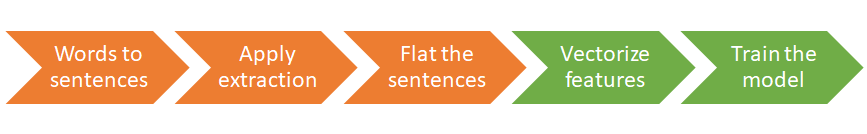
We must create our own transformer for the orange sections and we will use Scikit Learn's vectorizer and estimator for the green steps. Our output from applying extraction will not be numerical so we need a vectorizer turn this numerical.

But before going any step further, it is time to split the data.

### Splitting the data<a class="anchor" id="H9"></a>
We split the data 60%, 20% and 20% to training set, validation set and testing set. Because Sklearn's train_test_split function can split only one data set at a time, we need calculate the second split. The first split is 80:20 as we want 20% left out for testing set and after that we want a ratio that splits the remaining 80% to validation set of 20% and training set of 60%: 
<br>$split_2*0.80 = 0.20 $ 
<br>$split_2 = 0.20 / 0.80$ 
<br>$= 0.25 $

There is still one problem. We cannot split the words randomly because the orders of words in a sentence are important for our transformer. We can either first structure the data to sentences and get slightly incorrect split ratios or first transform the data to features and then split by words. However, the latter prevents us from piping the transformer conveniently with the classifier thus we accept the slight inaccuracy of split ratios. This also marginally reduce the randomness in our splits as the words in sentences are not random.

We also want to get rid of the index "_#_" as the order of words in a sentence is obvious and maintained. In addition, we reduce the data to 2 000 sentences because my laptop is not very resourceful. We do the reduction with random sampling as we cannot be sure that the order of sentences in the file is random.

In [10]:
from sklearn.model_selection import train_test_split
import numpy as np

# Setting random states for
# reproductability:
random_state = 44 
np.random.seed(random_state)

# Removing the word position index
df.index = df.index.droplevel('#')

# and reducing the sample size with random sampling
random_sample = np.random.choice(df.index.unique(), 
                                 2000,replace=False)
df = df.loc[random_sample]

# Now to the actual splitting
X, y = df['Word'], df['Part of Speech']

train_valid_index, test_index = train_test_split(df.index.unique(), test_size=0.2, random_state=random_state)
train_index, valid_index = train_test_split(train_valid_index, test_size=0.25, random_state=random_state)

X_test, y_test   = X.loc[test_index],  y.loc[test_index]
X_valid, y_valid = X.loc[valid_index], y.loc[valid_index]
X_train, y_train = X.loc[train_index], y.loc[train_index]


print(
    pd.DataFrame([
    [y_test.shape[0],  '{:.1f} %'.format(round(y_test.shape[0]/df.shape[0], 3)*100)],
    [y_valid.shape[0], '{:.1f} %'.format(round(y_valid.shape[0]/df.shape[0], 3)*100)],
    [y_train.shape[0], '{:.1f} %'.format(round(y_train.shape[0]/df.shape[0], 3)*100)],
    [df.shape[0], '{:.1f} %'.format(round((y_train.shape[0]+y_valid.shape[0]+y_test.shape[0])/df.shape[0], 3)*100)]
    ], 
    index = ['Size of test','Size of validation','Size of train', 'Total'],
    columns = ['Size','Ratio'])
     )


                     Size    Ratio
Size of test         5080   18.6 %
Size of validation   5616   20.5 %
Size of train       16669   60.9 %
Total               27365  100.0 %


Split ratios seem to be adequate and we move on to make the transformer.

### Transformation and Feature Engineering<a class="anchor" id="H10"></a>
We pick some features from the actual word and some features related to the position of the word in the sentence. We will start with checking if the word is in upper or lower case, is capitalized, has hypend or is number. We also take the last 1, 2 and 3 letters of a word, word's length and the word itself. Finnish words have hypends if they are combination words with same vowels in the intersection (ie. _virka-asia_). Generally prefixes hold little importance in Finnish. From the sentence, we use the information of what was the previous word and what is the next word, and if the word is first or last in the sentence.

The transformer is the largest block of code we need to write. We build it as a Python class and inherit BaseEstimator and TransformerMixin from Scikit Learn to make it work as a component of Scikit Learn's pipeline. The most confusing part of the transformer could be that we pass the extraction method's name as an argument and then convert the name to the extraction function itself with built-in function _getattr_. We do so to make the extraction method as a replaceable component but more of this later. This trick keeps the script DRY (Don't repeat yourself).

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin



class WordFeatureExtractor(BaseEstimator, TransformerMixin):

    
    def __init__(self, extraction_function='extraction_simple'):
        'Transforms pandas series to list of word features'
        
        # We pass "extraction_function" as an argument
        # so we can later add new extraction methods
        # with means of inheritage
        
        self.extraction_function = extraction_function
        
    def fit(self, X, y=None):
        
        # There is nothing to fit on here but
        # Sklearn pipeline requires a fit method
        
        return self

    
    def transform(self, X):
        'Transform a pandas series of words to list of dictionaries'
        
        # Next we turn the series to list of words that are in list of sentences
        # We use groupby to group the series by sentence, then we turn each sentence
        # to list with lambdas (sent.values.tolist()) and finally we turn the whole 
        # series to list.
        X_sents = X.groupby(X.index.names, sort=False).apply(lambda sent: sent.values.tolist()).tolist()
        return self._transform_sentences(X_sents)

    
    def _transform_sentences(self, X):
        'Transforms list of sentences to list of dictionaries'
        
        # The method's name starts with underscore
        # to indicate a private method.
        # This method relies on the attribute:
        # "extraction_function"
        
        X_transformed = []
        for sentence in X:
            for word_index in range(len(sentence)):
                # index is a position of a word
                # in a sentence
                extractor = getattr(self, self.extraction_function)
                x_dict = extractor(sentence, word_index)
                # or directly change to "x_dict = self.extraction_simple(sentence, word_index)"
                
                X_transformed.append(x_dict)
        return X_transformed


    def extraction_simple(self, sentence, index):
        return {
                'word': sentence[index],
                'length': len(sentence[index]),
                'has_hyphen': '-' in sentence[index],
                'is_first': index == 0,
                'is_last': index == len(sentence) - 1,
                'is_capitalized': sentence[index].capitalize() == sentence[index],
                'is_upper': sentence[index].isupper(),
                'is_lower': sentence[index].islower(),
                'is_digit': sentence[index].isdigit(),
                'suffix_1': sentence[index][-1:],
                'suffix_2': sentence[index][-2:],
                'suffix_3': sentence[index][-3:],
                'prev_word': sentence[index - 1] if index > 0 else '',
                'next_word': sentence[index + 1] if index < len(sentence) - 1 else '',
                }
    

Next we test the output of our transformer. We take the the first sentence in training set check how the second word looks like.

In [12]:
extr = WordFeatureExtractor()
extr.transform(X_train.loc[X_train.index[0]])[1]

{'has_hyphen': False,
 'is_capitalized': True,
 'is_digit': False,
 'is_first': False,
 'is_last': False,
 'is_lower': False,
 'is_upper': False,
 'length': 16,
 'next_word': 'tarkoitetaan',
 'prev_word': '1.1.2.2',
 'suffix_1': 'a',
 'suffix_2': 'la',
 'suffix_3': 'lla',
 'word': 'Ohjausvaihteella'}

The transformer seems to be working correctly. Next we can set up our pipeline.
As our transformer produces list of dictionaries, we need to convert these to numerical matrixes. Fortunately Sklearn has DictVectorizer which handles all of the transformation for us: dict to matrix and strings to dummies. It also remembers the feature names from the fit method in case we want to inspect them later.

We are going to use Decision Tree classifier. It is a good choice for the task as it is fast. It is also prone to overfit but it should not be a big deal here: Finnish language is known for lack of exceptions.

Lets get to it.

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer


pos_tagger = Pipeline([
    ('extractor',WordFeatureExtractor()),
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', DecisionTreeClassifier(criterion='gini'))
    ])

pos_tagger.fit(X_train, y_train);

Our model is now trained and ready to put on test. 

In [14]:
from sklearn import metrics
y_pred = pos_tagger.predict(X_valid)
print(metrics.classification_report(y_valid, y_pred))
print('Accuracy: {:.1f}%'.format(round(metrics.accuracy_score(y_valid, y_pred), 3)*100))

             precision    recall  f1-score   support

          A       0.76      0.53      0.63       412
       Abbr       0.88      0.88      0.88         8
        Adp       0.94      0.92      0.93       126
        Adv       0.88      0.90      0.89       164
      AgPcp       0.67      0.29      0.40        21
         CC       1.00      0.99      0.99       282
         CS       1.00      1.00      1.00        94
          N       0.88      0.95      0.91      2438
   NON-TWOL       0.84      0.50      0.63       101
        Num       0.99      0.97      0.98       559
     PrfPrc       0.90      0.85      0.87       214
       Pron       0.94      0.96      0.95       355
     PrsPrc       0.87      0.81      0.84       166
          V       0.91      0.92      0.91       676

avg / total       0.90      0.90      0.89      5616

Accuracy: 90.0%


90% accuracy is not bad at all and percision and recall seem to be somewhat balanced. We care evenly correct classifications, whether it is negative or positive for a class, so there should be little reason to weight recall or percision of a class over the other. Our model does not perform well on agent particles or NON-TWOL most likely because they are somewhat rare but on the other hand coordinating conjunction (CS) it did classify completely correctly even though the class size is small.

Next we will go a bit deeper on what the model confuses and gets wrong. We will use confusion matrix for the job

In [15]:
import matplotlib.pyplot as plt

def plot_confusion(y_true, y_pred):
    conf = metrics.confusion_matrix(y_true, y_pred)
    conf_norm = conf / conf.sum(axis=1, keepdims=True)
    labels = np.unique(np.concatenate((y_true, y_pred), axis=0))
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_norm, cmap='RdYlGn_r', interpolation='nearest')
    fig.colorbar(cax)

    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))

    ax.set_xticklabels(list(labels), rotation='vertical')
    ax.set_yticklabels(list(labels))
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    return ax

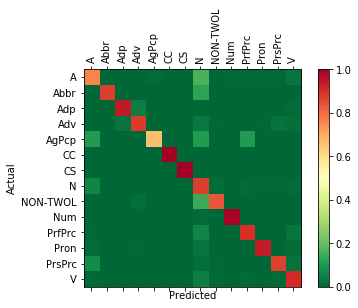

In [16]:
%matplotlib inline
# %matplotlib inline is a method of
# Jupyter Notebook to embed plots.
# Don't copy it to your script.

plot_confusion(y_pred, y_valid)
plt.show()

The confusion matrix plot above is normalized with the actual value (horizontally). For example, agent particles (AgPcp) are clearly confused to nouns (N) and adjectives (A) but about 50% of them are classified right.

The imbalance of tags is visible in this plot: The model tags other classes as nouns, which is the largest class, but does not confuse nouns to other classes as easily (the vertical line of N is more colourful than the horizontal line of N). 
However, the most important observation here is that adjectives, which is fourth larges group and has third worst score, are often confused with nouns.

In [17]:
def get_example_dict(x, y_pred, y_true):
    '''Returns a dictionary with examples
    Structure : {True values: {Predicted values: [List of examples]}}'''
    
    x = np.array(x)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    labels = np.unique(np.concatenate((y_true, y_pred), axis=0))
    examples = {true_label:{pred_label:[] for pred_label in labels} for true_label in labels}
    for index in range(len(y_true)):
        examples[y_true[index]][y_pred[index]].append(x[index])
    return examples

In [18]:
get_example_dict(X_valid, y_pred, y_valid)['A']['N'][:5]

['mukainen',
 'myönnettävistä',
 'tavanomaisen',
 'mittanormaalia',
 'ETY-mittanormaalia']

The above five words are examples of words that were mistaken as nouns even though they are adjectives. I won't go details what these words mean but in Finnish the lengths of the words above resemble typical noun and the last three letters could easily exist in a noun. My hypothesis is that those words are incorrectly classified due to that the last three letters at the end are not enough to distinguish the difference.

An easy solution would be to add just more letters to the suffix features. However, as I was digging deeper to the problem I got a better idea: in Finnish, syllables play significant role. Syllables are usually about three letter strings that make up the words. I don't know how it works in English but in Finnish you could divide word such as "myönnettävistä" to the following syllables "myön-net-tä-vis-tä". Together those last two syllables are very hard to confuse with nouns or any other PoS tags. Coming up with a proper syllable splitter involved getting my hands on The Dictionary of Modern Finnish and playing awhile with regular expressions.

I found out that a syllable ends to:
<br> A) consonant, that is not the last letter in a way that next syllable starts one and only one consonant,
<br> B) third vowel if there are more than two sequential vowels or
<br> C) second vowel in a sequence of two vowels in some rarer cases for an unknown reason  

After experimenting with regular expressions, I came up with the following string:
[bcdfghjklmnpqrstvxzw]?[aeiouyäö]{1,2}(?:(?=[aeiouyäö])|[bcdfghjklmnpqrstvxzw]{0,2}$|[bcdfghjklmnpqrstvxzw]{0,3}(?=[-bcdfghjklmnpqrstvxzw]))

<br> To break this down:
1. [bcdfghjklmnpqrstvxzw]? means that the syllable can start with a consonant or without (qualifier "_?_")
2. Then the syllable can have one or two vowels: [aeiouyäö]{1,2}
2. And then the syllable either end
<br> to third vowel without capturing it: (?=[aeiouyäö]), or 
<br> to consontants that are at the end of the word: [bcdfghjklmnpqrstvxzw]{0,2}$, or
<br> to the second last consonant in sequential consonants: [bcdfghjklmnpqrstvxzw]{0,3}(?=[-bcdfghjklmnpqrstvxzw]

Next we try this out:

In [19]:
import re
re.findall(('[bcdfghjklmnpqrstvxzw]?[aeiouyäö]{1,2}(?:(?='
            '[aeiouyäö])'
            '|[bcdfghjklmnpqrstvxzw]{0,2}$'
            '|[bcdfghjklmnpqrstvxzw]{0,3}(?=[-bcdfghjklmnpqrstvxzw]))'),
           'myönnettävistä')

['myön', 'net', 'tä', 'vis', 'tä']

It works as we expected. Now we just need to apply this to our extractor. Because copy-pasting code is ugly, we just make an advanced feature transformer that inherits all the other methods of the original transformer.

In [20]:
class WordFeatureExtractorExtended(WordFeatureExtractor):
    
    # We set the regular expression by putting the vowels and
    # consonants with .format method. This way it is slightly
    # more readable but note the double curly brackets in the 
    # numerical qualifiers. The doubles do get removed by itself.
    
    syllable_expr = r'[{con}]?[{vow}]{{1,2}}(?:(?=[{vow}])|[{con}]{{0,2}}$|[{con}]{{0,3}}(?=[-{con}]))'.format(
        con='bcdfghjklmnpqrstvxzw', vow='aeiouyäö')
        
    
    def extraction_complex(self, sentence, index):
        'Extract word features with syllables'
        
        # We normalize the word (turn lower case) 
        # as I don't think capitalization 
        # plays a role here.
        word_normalized = sentence[index].lower()
        
        # Split the word according to the syllables
        splitted = re.findall(
            self.syllable_expr, word_normalized)
        
        # We also take the last syllable in the previous 
        # and in next word
        splitted_prev = '' if index == 0 else re.findall(
            self.syllable_expr, sentence[index-1])

        splitted_next = '' if index == len(sentence) - 1 else re.findall(
            self.syllable_expr, sentence[index+1])
        
        return {
                'word': sentence[index],
                'length': len(sentence[index]),
                'is_first': index == 0,
                'is_last': index == len(sentence) - 1,
                'is_upper': sentence[index].isupper(),
                'is_lower': sentence[index].islower(),
                'is_digit': sentence[index].isdigit(),
                'is_capitalized': sentence[index].capitalize() == sentence[index],
                'suffix_1': splitted[-1] if len(splitted) > 1 else '',
                'suffix_2': splitted[-2] if len(splitted) > 2 else '',
                'suffix_3': splitted[-3] if len(splitted) > 3 else '',
                'prev_word_suffix': splitted_prev[-1] if len(splitted_prev) > 0 else '',
                'next_word_suffix': splitted_next[-1] if len(splitted_next) > 0 else '',
                'has_hyphen': '-' in sentence[index]
                }

    

Some might argue that we made the code unnecessarily complicated with the _getattr_ trick. In fact, we could have avoided using the function by overriding the original extractor. This is simply done by naming the new method in the new class with the same name as it is in the parent class (in this case WordFeatureExtractor). However, doing so prevents testing multiple extraction methods with grid search or with other automatic hyper parameter tuning tools as they allow changing only the arguments in the initiation (considered as hyper parameters in this context). On the other hand, you probably should just use one class containing all of your extraction methods instead of using inheritage as we did here. The only reason we used inheritage was to keep this guide clean and easier to follow.

But now to test the updated model:

In [21]:
extr = WordFeatureExtractorExtended(extraction_function='extraction_complex')
extr.transform(X_train.loc[X_train.index[0]])[1]

{'has_hyphen': False,
 'is_capitalized': True,
 'is_digit': False,
 'is_first': False,
 'is_last': False,
 'is_lower': False,
 'is_upper': False,
 'length': 16,
 'next_word_suffix': 'taan',
 'prev_word_suffix': '',
 'suffix_1': 'la',
 'suffix_2': 'teel',
 'suffix_3': 'vaih',
 'word': 'Ohjausvaihteella'}

Works great. Now just update the pipeline, fit it and predict the validation set just as before.

In [22]:
pos_tagger_adv = Pipeline([
    ('extractor',WordFeatureExtractorExtended(extraction_function='extraction_complex')),
    ('vectorizer', DictVectorizer(sparse=False)),
    ('classifier', DecisionTreeClassifier(criterion='gini'))
    ])

pos_tagger_adv.fit(X_train, y_train);

In [23]:
y_pred = pos_tagger_adv.predict(X_valid)
print(metrics.classification_report(y_valid, y_pred))
print('Accuracy: {:.1f}%'.format(round(metrics.accuracy_score(y_valid, y_pred), 3)*100))

             precision    recall  f1-score   support

          A       0.87      0.74      0.80       412
       Abbr       0.55      0.75      0.63         8
        Adp       0.94      0.94      0.94       126
        Adv       0.85      0.90      0.88       164
      AgPcp       0.35      0.33      0.34        21
         CC       1.00      0.99      1.00       282
         CS       0.99      1.00      0.99        94
          N       0.90      0.95      0.93      2438
   NON-TWOL       0.78      0.38      0.51       101
        Num       0.97      0.98      0.98       559
     PrfPrc       0.87      0.90      0.88       214
       Pron       0.94      0.95      0.94       355
     PrsPrc       0.91      0.83      0.87       166
          V       0.93      0.90      0.92       676

avg / total       0.91      0.91      0.91      5616

Accuracy: 91.5%


See the difference? We increased precision of adjectives about 0.11 and recall about 0.21. This means that the model is now more eager to classify words to adjectives (recall) and at the same time classifies fewer non adjectives as adjectves (precision). Also, accuracy rose 1.5% which is something.

## Final Evaluation and Conclusion<a class="anchor" id="H11"></a>
We could increase the accuracy with similar tricks we did endlessly but the model is already adequate. You could, for example, make the model recursive meaning that you fit the model also using the tags from previous words and predict the first words per sentence, then add the predictions to the next words' features and predict the tag of that word and so on. You could also try different algorithms or remove or add new features. However, small increases of accuracy many times require expontentially complex and resource intensive models. 

Next we just get the final accuracy scores from the test set. We did not take many steps in our validation phase but we had too much data not to spend on untouched test set.

In [24]:
y_pred = pos_tagger_adv.predict(X_test)
print('Final Score')
print(metrics.classification_report(y_test, y_pred))
print('Accuracy: {:.1f}%'.format(round(metrics.accuracy_score(y_test, y_pred), 3)*100))

Final Score
             precision    recall  f1-score   support

          A       0.87      0.73      0.79       345
       Abbr       0.72      0.81      0.76        16
        Adp       0.95      0.91      0.93       109
        Adv       0.89      0.84      0.86       158
      AgPcp       0.44      0.29      0.35        14
         CC       1.00      1.00      1.00       265
         CS       1.00      0.97      0.99       115
          N       0.89      0.95      0.92      2132
   NON-TWOL       0.43      0.16      0.24        61
        Num       0.98      0.98      0.98       523
     PrfPrc       0.84      0.84      0.84       186
       Pron       0.92      0.93      0.93       334
     PrsPrc       0.96      0.84      0.89       160
          V       0.91      0.89      0.90       662

avg / total       0.91      0.91      0.91      5080

Accuracy: 91.0%


The accuracy score is fine and the model is ready for production. You can save the model on your disk with pickle or joblib to use it later or in another script. Also, depending on the structure of your to-be-tagged data, you may want to bypass the series to list section in the transform method. This can be done with simple checking of the data type (ie. "_if isinstance(X, pd.Series):_") or using a setter and an _if_ statement. 



In [25]:
import pickle
import sys
mdl_1 = pickle.dumps(pos_tagger)
mdl_2 = pickle.dumps(pos_tagger_adv)

mdl_1_memory = sys.getsizeof(mdl_1)
mdl_2_memory = sys.getsizeof(mdl_2)
print('Memory of the first model:  {} bytes.'.format(mdl_1_memory))
print('Memory of the second model: {} bytes.'.format(mdl_2_memory))
print('Memory consumption change:  {:.1f}%'.format(round((mdl_2_memory-mdl_1_memory)/mdl_1_memory*100),1))

Memory of the first model:  1312174 bytes.
Memory of the second model: 845743 bytes.
Memory consumption change:  -36.0%


With some clever diagnosis of the problem we even managed to reduce the memory consumption of our model over one third! It is cruicial to know the specifics of the language you are dealing with and adjust the features according to it. Your estimator can never outperform the features you feed it with. But can you do better than this model? Try and mess with the code.

I hope you enjoyed reading this tutorial as much as I enjoyed writing it. You can get my current version of the tagger from my Github: https://github.com/Miksus/Syntags

In case you liked my guide and you have opportunities for me, please contact me via email: koli.mikael@gmail.com